In [ ]:
import joblib
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.figure_factory as ff
import plotly.graph_objects as go
from sklearn.preprocessing import minmax_scale
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import StratifiedKFold, cross_validate
import seaborn as sns
from tqdm import tqdm

import bin.linkprediction as lp

In [89]:
def report(d: cross_validate):
  param_grid = d['estimator'][0].cv_results_['params']
  return pd.DataFrame.from_dict(
    {
      tuple(params.values()):
      {
        "mean_train": np.mean([estimator.cv_results_[f'split{i}_train_score'][idx] for estimator in d['estimator'] for i in range(5)]),
        "std_train": np.std([estimator.cv_results_[f'split{i}_train_score'][idx] for estimator in d['estimator'] for i in range(5)]),
        "mean_val": np.mean([estimator.cv_results_[f'split{i}_test_score'][idx] for estimator in d['estimator'] for i in range(5)]),
        "std_val": np.std([estimator.cv_results_[f'split{i}_test_score'][idx] for estimator in d['estimator'] for i in range(5)]),
        "mean_fit_time": np.mean([estimator.cv_results_[f'mean_fit_time'][idx] for estimator in d['estimator'] for i in range(5)])/60
      }
      for idx, params in enumerate(param_grid) 
    }
  ).T.rename_axis(param_grid[0].keys())

In [104]:
pd.concat(
  [
    report(joblib.load('temp/a1/xgb_hist_maxdepth1.pkl')),
    report(joblib.load('temp/a1/xgb_all_maxdepth234.pkl'))
  ]
).sort_index('index', 'tree_method')

,,mean_fit_time,mean_train,mean_val,std_train,std_val
max_depth,tree_method,,,,,
2,approx,20.063836,0.005084,0.004673,0.000267,0.000620
3,approx,27.141176,0.006092,0.004712,0.000322,0.000777
4,approx,34.437127,0.007886,0.004905,0.000462,0.000994
2,exact,9.261389,0.005725,0.004740,0.000343,0.000777
3,exact,14.563005,0.007223,0.005063,0.000509,0.000949
4,exact,15.790677,0.009604,0.004701,0.000748,0.000914
1,hist,1.967845,0.004824,0.004820,0.000309,0.000706
2,hist,2.126656,0.005347,0.004833,0.000292,0.000773
3,hist,2.376121,0.006748,0.004978,0.000387,0.000753


In [92]:
df = report(joblib.load('temp/a1/xgb_hist_maxdepth12_scalers.pkl'))

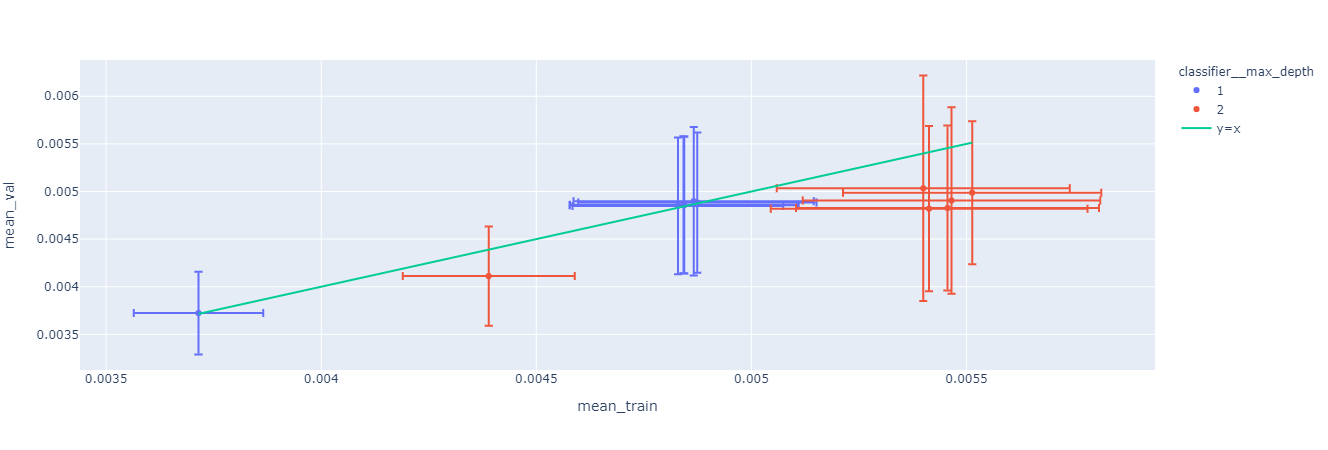

In [132]:
fig = px.scatter(
  df.reset_index().astype(dict(classifier__max_depth=str)), 
  x="mean_train", 
  y="mean_val", 
  color="classifier__max_depth", 
  hover_name=df.index.get_level_values('scaler').astype('str'), 
  error_x="std_train",
  error_y="std_val"
)
fig.add_trace(go.Scatter(x=df['mean_train'].agg(['min', 'max']), y=df['mean_train'].agg(['min', 'max']), name="y=x", mode='lines'))